1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



32.97989844019469


Text(0.5, 0, 'annual wind speed maxima [m/s]')

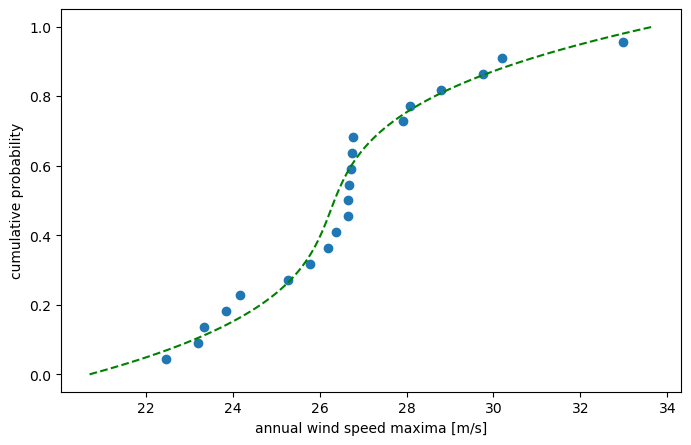

In [6]:
#import the dataset
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

#compute the cumulative probability
p_i = [ i/(years_nb+1) for i in range(1,years_nb+1)]

#plot the cumulative probabilities
import matplotlib.pyplot as plt
max_sorted = np.sort(max_speeds)
fig = plt.figure(figsize=(8, 10))
cumulative = fig.add_subplot(1, 1, 1, aspect=8)
cumulative.scatter(max_sorted, p_i)

#perform the fit
from scipy.interpolate import UnivariateSpline
q_func = UnivariateSpline(p_i, max_sorted)
fifty_prob = 1. - 0.02
fifty_wind = q_func(fifty_prob) #retrieve the percentile from the fit
print(fifty_wind)

#plot the fit curve
y_USpline = np.linspace(0, 1, 100) 
x_USpline = q_func(y_USpline)

cumulative.plot(x_USpline, y_USpline,'g--')
plt.ylabel("cumulative probability")
plt.xlabel("annual wind speed maxima [m/s]")


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Text(0.5, 1.0, 'Temperatures minima and maxima per month in Alaska')

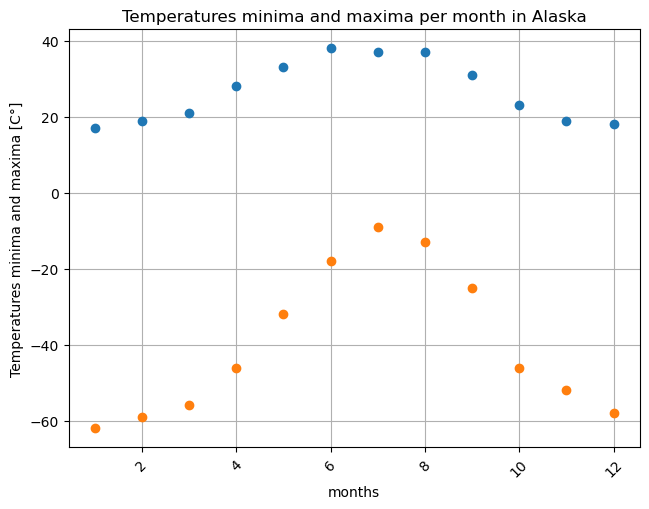

In [13]:
#1)Plot these temperature extremes

#prepare the data
max_T = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_T = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
month = np.arange(1,13)
#month = np.array(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])

#plot the data
plt.figure()
plt.plot(month, max_T, 'o')
plt.plot(month, min_T, 'o')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.xlabel("months")
plt.ylabel("Temperatures minima and maxima [C°]")
plt.title("Temperatures minima and maxima per month in Alaska")

In [14]:
#2) Define a function that can describe min and max temperatures. 

#looking at the data distribution we have a strong prior...
import math as m

def temp_describer(x, A, B, nu, delta):
    return A+B*np.sin(nu*x + delta)

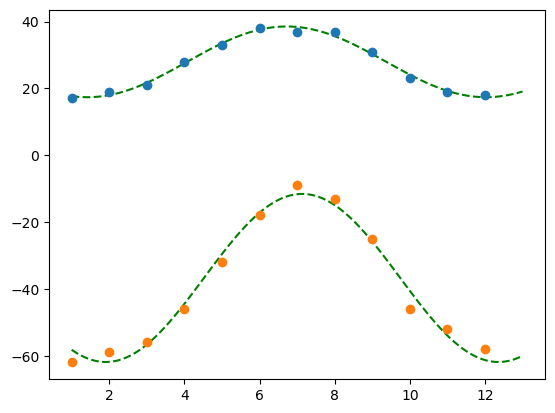

In [19]:
#Fit this function to the data with scipy.optimize.curve_fit()

from scipy import optimize

params_min, params_covariance_min = optimize.curve_fit(temp_describer, month, min_T, p0=[np.mean(min_T), np.max(min_T)-np.min(min_T), 2*np.pi/13, np.pi/4])
params_max, params_covariance_max = optimize.curve_fit(temp_describer, month, max_T, p0=[np.mean(min_T), np.max(max_T)-np.min(max_T), 2*np.pi/13, np.pi/4])

x = np.linspace(1,13,100)

plt.figure()
plt.plot(x, temp_describer(x, params_min[0], params_min[1], params_min[2], params_min[3]), 'g--')
plt.plot(x, temp_describer(x, params_max[0], params_max[1], params_max[2], params_max[3]), 'g--')
plt.plot(month, max_T, 'o')
plt.plot(month, min_T, 'o')


3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


Text(0.5, 1.0, 'Camelbck function color map')

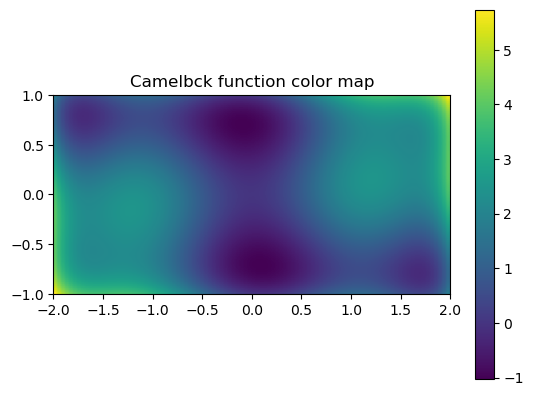

In [39]:
def camelback(xy):
    x,y = xy
    return (4 - 2.1*(x**2) + (x**4)/3)*(x**2) + (x*y) + (4*(y**2) - 4)*(y**2)

#built up a mesh to plot the function
import numpy as np
x = np.linspace(-2,2,100)
y = np.linspace(-1,1,100)
X,Y = np.meshgrid(x,y)
Z = camelback((X,Y))

#plot the functiona as a color map
plt.imshow(Z, extent=[-2, 2, -1, 1], origin='lower', cmap='viridis') 
plt.colorbar() 
plt.title('Camelbck function color map') 

In [54]:
#find the local minima
from scipy.optimize import minimize 

#define the initial points from the p[revious image
x0 = np.array(([-1.25,0.75],[0,0.75],[0,-0.75],[1.25,-0.75]))
minima = []
for point in x0:
    loc_min = minimize(camelback, point, method='BFGS')
    minima.append(loc_min.fun)
    print("Starting point:", point)
    print("Valore minimo:", loc_min.fun)
    print("Punto in cui si raggiunge il minimo:", loc_min.x)
    print("Successo:", loc_min.success)
    print("Messaggio:", loc_min.message, '\n')

print("The absolut minimum of the function is:", min(minima), '\n')

#What happens for an initial guess of x,y = 0,0 ?
loc_min = minimize(camelback, point, method='BFGS')
print("Starting point:", point)
print("Valore minimo:", loc_min.fun)
print("Punto in cui si raggiunge il minimo:", loc_min.x)
print("Successo:", loc_min.success)
print("Messaggio:", loc_min.message, '\n')

Starting point: [-1.25  0.75]
Valore minimo: -0.2154638243837158
Punto in cui si raggiunge il minimo: [-1.70360673  0.79608355]
Successo: True
Messaggio: Optimization terminated successfully. 

Starting point: [0.   0.75]
Valore minimo: -1.0316284534898768
Punto in cui si raggiunge il minimo: [-0.08984202  0.71265641]
Successo: True
Messaggio: Optimization terminated successfully. 

Starting point: [ 0.   -0.75]
Valore minimo: -1.0316284534898743
Punto in cui si raggiunge il minimo: [ 0.08984201 -0.71265642]
Successo: True
Messaggio: Optimization terminated successfully. 

Starting point: [ 1.25 -0.75]
Valore minimo: -0.2154638243837177
Punto in cui si raggiunge il minimo: [ 1.70360671 -0.79608357]
Successo: True
Messaggio: Optimization terminated successfully. 

The absolut minimum of the function is: -1.0316284534898768 

Starting point: [ 1.25 -0.75]
Valore minimo: -0.2154638243837177
Punto in cui si raggiunge il minimo: [ 1.70360671 -0.79608357]
Successo: True
Messaggio: Optimizati

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

(-0.5, 629.5, 473.5, -0.5)

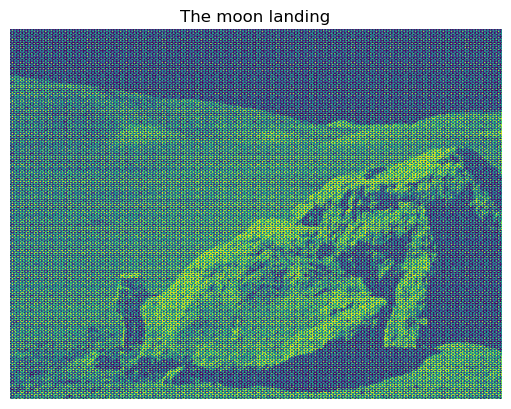

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib import pylab
from scipy import fftpack

# Load the image
image = pylab.imread('moonlanding.png') 

# Display the image 
plt.imshow(image) 
plt.title('The moon landing') 
plt.axis('off') # Hide axes 

(-0.5, 629.5, 473.5, -0.5)

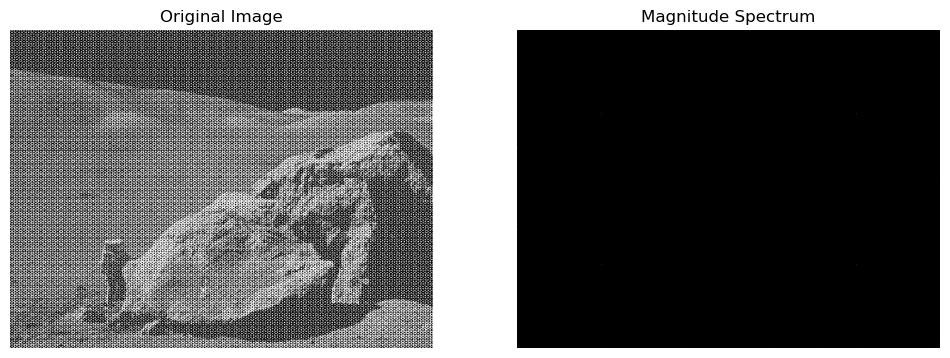

In [5]:
#perform the FFT
image_spectrum = np.fft.fft2(image)

#Visualize the image spectrum and the original one. First show the image: 
plt.figure(figsize=(12, 6)) 
plt.subplot(121) 
plt.imshow(image, cmap='gray') 
plt.title('Original Image') 
plt.axis('off') 

#Plot the magnitude spectrum 
plt.subplot(122) 
plt.imshow(abs(image_spectrum), cmap='gray') 
plt.title('Magnitude Spectrum') 
plt.axis('off') 

(-0.5, 629.5, 473.5, -0.5)

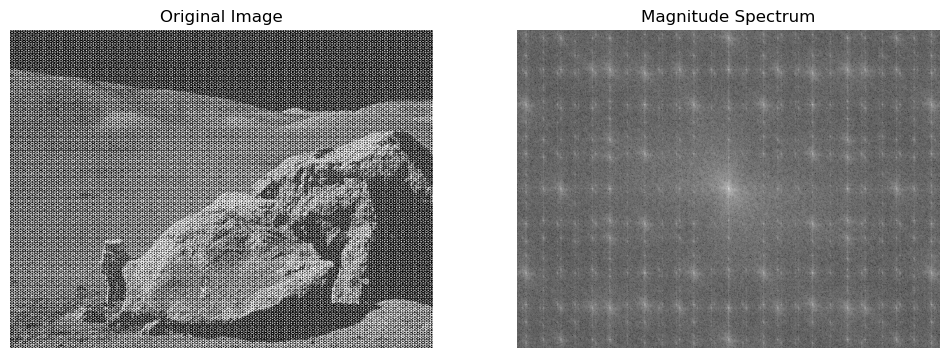

In [9]:
#In order to correctly visulaize the spectrum we need to plot the logaritmic value

# Shift the zero-frequency component to the center 
spectrum_shifted = np.fft.fftshift(image_spectrum) 

# Compute the magnitude spectrum 
magnitude_spectrum = np.log(np.abs(spectrum_shifted)) 

# Plot the original image 
plt.figure(figsize=(12, 6)) 
plt.subplot(121) 
plt.imshow(image, cmap='gray') 
plt.title('Original Image') 
plt.axis('off') 

# Plot the magnitude spectrum 
plt.subplot(122) 
plt.imshow(magnitude_spectrum, cmap='gray') 
plt.title('Magnitude Spectrum') 
plt.axis('off')

(-0.5, 629.5, 473.5, -0.5)

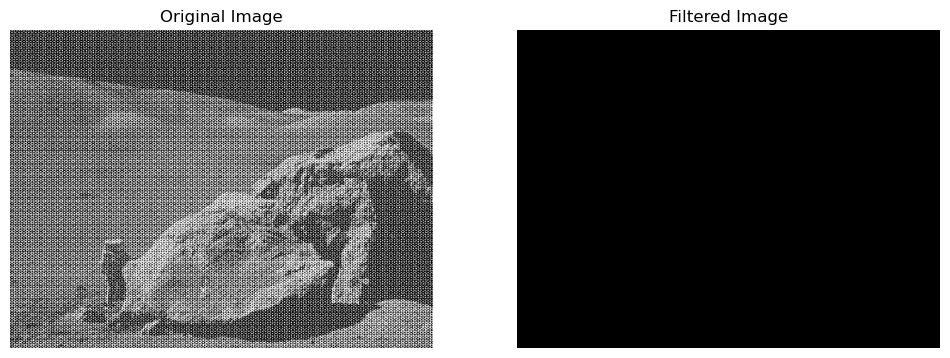

In [30]:
#Remove some high frequencies noise from the spectrum

# Create a low-pass filter 
rows, cols = image.shape 
crow, ccol = rows // 2 , cols // 2 
radius = 1 # Radius of the low-pass filter 
mask = np.zeros((rows, cols), np.uint8) 
center = (crow, ccol) 
x, y = np.ogrid[:rows, :cols] 
mask_area = (x - center[0])**2 + (y - center[1])**2 <= radius*radius 
mask[mask_area] = 1

# Apply the low-pass filter to the Fourier-transformed image 
filtered_transform = spectrum_shifted * mask 

# Perform the inverse FFT 
filtered_transform_shifted_back = np.fft.ifftshift(filtered_transform) 
filtered_image = np.fft.ifft2(filtered_transform_shifted_back) 
filtered_image = np.abs(filtered_image) 

# Plot the original and filtered images 
plt.figure(figsize=(12, 6)) 
plt.subplot(121) 
plt.imshow(image, cmap='gray') 
plt.title('Original Image') 
plt.axis('off') 
plt.subplot(122) 
plt.imshow(filtered_image, cmap='gray') 
plt.title('Filtered Image') 
plt.axis('off')